In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
from __future__ import print_function

import hosts
import targeting
import mmthecto
import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table
from astropy.table import Table
from astropy.io import fits

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)

In [5]:
hostlst = hosts.get_saga_hosts_from_google(useobservingsummary=True) #'named' hosts

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [6]:
candidates = """
NSAID    RA   DEC Name
   150887      23.2455      4.53406  N/A
    150578.      23.0824      12.3229  N/A
    149781.      22.3942     -3.43167  OBrother
    150307.      22.9283     -5.49535  N/A
    61945.0      23.6087     0.297265  AnaK
    149977.      22.6248      10.5315  N/A
    153017.      23.9904      20.7498  N/A
    126115.    0.0663717      20.7524  N/A
    127226.     0.579656     -8.39644  N/A
    129387.      1.40109      12.9175  N/A
    129237.      1.36327      17.5922  N/A
    132339.      2.63655     -1.31876 Narnia
    130133.      1.65181     -7.51266  N/A
    131531.      2.25767      6.00248  N/A
    130625.      1.88703      4.19576  N/A
"""
candidates = Table.read(candidates,format='ascii')

hostdct = dict([(h.name, h) for h in hostlst])
candhosts = [hostdct[name] if name in hostdct else hosts.NSAHost(int(nsaid)) 
         for nsaid, name in zip(candidates['NSAID'], candidates['Name'])]
candhosts

[<hosts.NSAHost object w/ name 'NSA150887'>,
 <hosts.NSAHost object w/ name 'NSA150578'>,
 <hosts.NSAHost object w/ name 'NSA149781'>,
 <hosts.NSAHost object w/ name 'NSA150307'>,
 <hosts.NSAHost object w/ name 'NSA61945'>,
 <hosts.NSAHost object w/ name 'NSA149977'>,
 <hosts.NSAHost object w/ name 'NSA153017'>,
 <hosts.NSAHost object w/ name 'NSA126115'>,
 <hosts.NSAHost object w/ name 'NSA127226'>,
 <hosts.NSAHost object w/ name 'NSA129387'>,
 <hosts.NSAHost object w/ name 'NSA129237'>,
 <hosts.NSAHost object w/ name 'Narnia' AKA: ['NSA132339']>,
 <hosts.NSAHost object w/ name 'NSA130133'>,
 <hosts.NSAHost object w/ name 'NSA131531'>,
 <hosts.NSAHost object w/ name 'NSA130625'>]

In [7]:
# now set to the latest base catalogs
for h in candhosts:
    h.fnsdss = 'catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [8]:
# actually make sure they're loaded here
for h in candhosts:
    h.get_sdss_catalog()
h.get_sdss_catalog() # just to see

objID,ra,dec,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,PCLASS_1,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT,U,B,V,R,I,rhost,rhost_kpc,type,phot_sg
int64,float64,float64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,string384,float64,float64,int64,int64,int64,int64,string32,string384,float64,string384,float32,float32,float32,float32,float32,float64,float64,int16,string48
1237678622239687293,28.2921893761,4.1654677952,387097114444048,0,24.8861,24.5384,22.9648,21.9456,21.3148,0.966116,0.565863,0.238203,0.135154,0.280791,0.19371,0.14253,0.103375,0.0783858,0.0555765,22.261,22.9741,0.132225,20.5668021324,0.641864,1.37584,22.9859,24.0185837122,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,17.9499,0.207252,16.003,0.175,-1.0,-1.0,-1,0.595791,0.082322,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,1.98200266096,13.114524378,-1,-1,-1,-1,,,-1.0,,25.4448,25.2499,23.6333,22.6919,21.3051,0.0330198482762,12.9620185552,3,GALAXY
1237678622239687535,28.2808531784,4.17348908215,281543964623616,0,24.2549,23.1379,21.9114,21.7858,21.6071,0.975535,0.212821,0.0979778,0.120167,0.359127,0.193723,0.142539,0.103381,0.078391,0.0555802,22.2951,22.7768,0.216964,20.5887781366,0.590522,1.3195,22.0478,22.8994797037,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,19.4984,0.848584,9999.0,9999.0,-1.0,-1.0,-1,-1.0,-1.0,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,1.98573241428,13.1392034243,-1,-1,-1,-1,,,-1.0,,24.1516,23.7408,22.4289,21.7752,21.3198,0.0330706320147,12.9819538303,6,STAR
1237678622239687551,28.2892305507,4.1666156998,281543964623104,0,23.538,23.6733,22.7989,22.2601,21.7235,0.647714,0.320625,0.201627,0.175092,0.371933,0.193668,0.142499,0.103352,0.078369,0.0555646,22.9504,23.4056,0.00149116,10.6619883934,-9999.0,-9999.0,27.0005,48.9956979059,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,17.5289,0.137348,9999.0,9999.0,-1.0,-1.0,-1,0.637883,0.137668,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,1.99849702866,13.2236643743,-1,-1,-1,-1,,,-1.0,,23.739,24.1659,23.1633,22.5995,21.656,0.0332919091918,13.0688167029,3,GALAXY
1237678661436375815,28.3178710528,4.22726178032,281543964623616,0,26.1572,22.1578,21.4868,20.0189,19.5865,1.65004,0.2729,0.266116,0.109058,0.29841,0.196014,0.144225,0.104604,0.079318,0.0562375,23.1452,23.5192,0.264709,21.7103790809,3.99238,6.47142,21.4839,26.4855161938,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,18.7934,0.469792,9999.0,9999.0,-1.0,-1.0,-1,0.9529,0.184473,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,2.03209360161,13.4459663078,-1,-1,-1,-1,,,-1.0,,24.2021,22.5868,21.7627,21.1452,19.455,0.0338807234169,13.2999571021,3,GALAXY
1237678661436375822,28.3379290684,4.18852269949,281475245277440,0,23.64,23.186,23.3671,21.5564,21.3618,0.947116,0.258817,0.522418,0.157588,0.518212,0.195576,0.143903,0.10437,0.079141,0.0561119,23.8665,24.1587,4.25089,27.4210324564,0.841304,1.10107,23.5624,25.1826394487,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,17.6542,0.157534,9999.0,9999.0,-1.0,-1.0,-1,0.465791,0.248365,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,1.99436115266,13.1962980939,-1,-1,-1,-1,,,-1.0,,22.6684,23.3483,23.2723,22.973,21.0843,0.0332725715253,13.0612256568,3,GALAXY
1237678622239687292,28.2917688682,4.16479395685,35253360001296,0,24.8854,22.4322,20.8396,20.1583,19.794,1.14023,0.136569,0.0478744,0.0372707,0.0961961,0.193663,0.142496,0.10335,0.0783669,0.0555631,21.3316,21.8734,0.49728,21.3671699956,0.739849,1.4289,20.

# Testing w/ NSA 150887

In [9]:
n150887 = candhosts[0]
hosts_to_target = [n150887]

In [10]:
p_column_for_ranking = 'PROBABILITY_CLASS_1' #this is *just* SDSS

In [11]:
mlpred = Table.read('catalogs/SAGA.ALL.objid_rescaledrobs_pred.Oct28_SDSS_nopreclean.csv.fits.gz')
mlpred['objID'] = mlpred['OBJID'] # used for matching
mlpred

OBJID,RA,DEC,DERED_R,PROBABILITY_CLASS_1,RESCALED_PROBABILITY_CLASS_1,BEST_GUESS_CLASS,objID
int64,float64,float64,float64,float64,float64,int64,int64
1237645941824356440,40.2877964113,-0.735647060949,16.7594,0.00157168316197,0.000345859198981,0,1237645941824356440
1237645941824356442,40.2745834514,-0.733014063478,17.4514,0.000372493836691,8.19307625291e-05,0,1237645941824356442
1237645941824356481,40.2721052363,-0.642510253204,16.7911,0.00178514575454,0.000358794024809,0,1237645941824356481
1237645941824356483,40.2712777717,-0.640725293001,20.9894,0.000240454811286,5.13915737065e-05,0,1237645941824356483
1237645941824356484,40.2783697699,-0.641212507445,21.2884,0.000270864809902,5.63874521068e-05,0,1237645941824356484
1237645941824356485,40.2826647047,-0.642892947061,22.4926,3.61806080935e-05,0.0,0,1237645941824356485
1237645941824356497,40.2846730128,-0.817180215799,14.8628,0.000363130559728,8.19307625291e-05,0,1237645941824356497
1237645941824356500,40.2881452154,-0.805045508948,14.3826,0.000488674982738,8.85746681048e-05,0,1237645941824356500
1237645941824356501,40.2854134086,-0.804100473432,20.2454,0.000763301466982,0.000162326503484,0,1237645941824356501


In [12]:
joined_catalogs = {}
for h in hosts_to_target:
    #filter on manual remove lists *and* REMOVE!=-1
    cat = targeting.remove_targets_with_remlist(h.get_sdss_catalog(), h, 'catalogs/TargetRemoveAug28_2015.csv')
    
    pre_joined = table.join(cat, mlpred, join_type='left', keys='objID')
    
    tokeep = pre_joined['REMOVE']==-1
    notobserved = pre_joined['ZQUALITY']<3
    print('removed', np.sum(~tokeep),'for remove list and', np.sum(~notobserved),'b/c observed')
    joined_catalogs[h] = pre_joined[tokeep&notobserved]
    highp = pre_joined[p_column_for_ranking]>0.01
    print('n w/ ML pred>0.01 and observed:', np.sum(highp&~notobserved), 'not yet obs:', np.sum(highp&notobserved))

Removed 4 objects for NSA150887
removed 250 for remove list and 722 b/c observed
n w/ ML pred>0.01 and observed: 7 not yet obs: 506


## No redmapper 

In [13]:
# compute ranks, which includes filtering on mag
rankdct = {}
for h in hosts_to_target:
    cat = joined_catalogs[h]
    
    
    highprob = cat[p_column_for_ranking].filled(0) > 0.5
    medprob = (cat[p_column_for_ranking].filled(0) > 0.05) & ~highprob
    lowprob = (cat[p_column_for_ranking].filled(0) > 0.01) & ~highprob & ~medprob
    inside = cat['RHOST_KPC']<300
    
    rankdct[h] = ranks = np.ones(len(cat), dtype=int)*-1 #the -1 will be re-set at the end
    
    # rank 1 reserved for flux stars
    ranks[inside&highprob] = 2
    ranks[~inside&highprob] = 3
    ranks[inside&medprob] = 4
    ranks[~inside&medprob] = 5
    ranks[inside&lowprob] = 6
    ranks[~inside&lowprob] = 7
    
    validtarget = (cat['r'] < 21.5) & (cat['fibermag_r']<23) & (cat['phot_sg']=='GALAXY')
    other = ranks < 0
    colorcutmsk = targeting.colorcut_mask(cat,  targeting.bossanova_color_cuts)
    
    ranks[validtarget&other&colorcutmsk] = 8
    ranks[validtarget&other&~colorcutmsk] = 9
    
#informational
for h, ranks in rankdct.items():
    cat = joined_catalogs[h]
    
    hranks = dict(enumerate(np.bincount(ranks[ranks>-1])))
    del hranks[0]
    del hranks[1]
    hranks[-1] = np.sum(ranks==-1)
    
    print(h.name,'rank counts:', hranks)
    
    nother =  np.sum(ranks==8)
    nprob = np.sum((ranks<8)&(ranks>0))
    nother_obs = 270-np.sum((ranks<8)&(ranks>0)&(cat['RHOST_ARCM']<30))
    print('fraction not "other": {0:.1%}, nprob_obs={1}\n'.format(nprob/(nprob+nother), nother_obs))

NSA150887 rank counts: {2: 3, 3: 3, 4: 52, 5: 84, 6: 80, 7: 251, 8: 9483, 9: 7581, -1: 51746}
fraction not "other": 4.8%, nprob_obs=120



In [33]:
a = 2

## Sanity-checks

### are the ML-selected objects meeting the fibermag and r cuts?

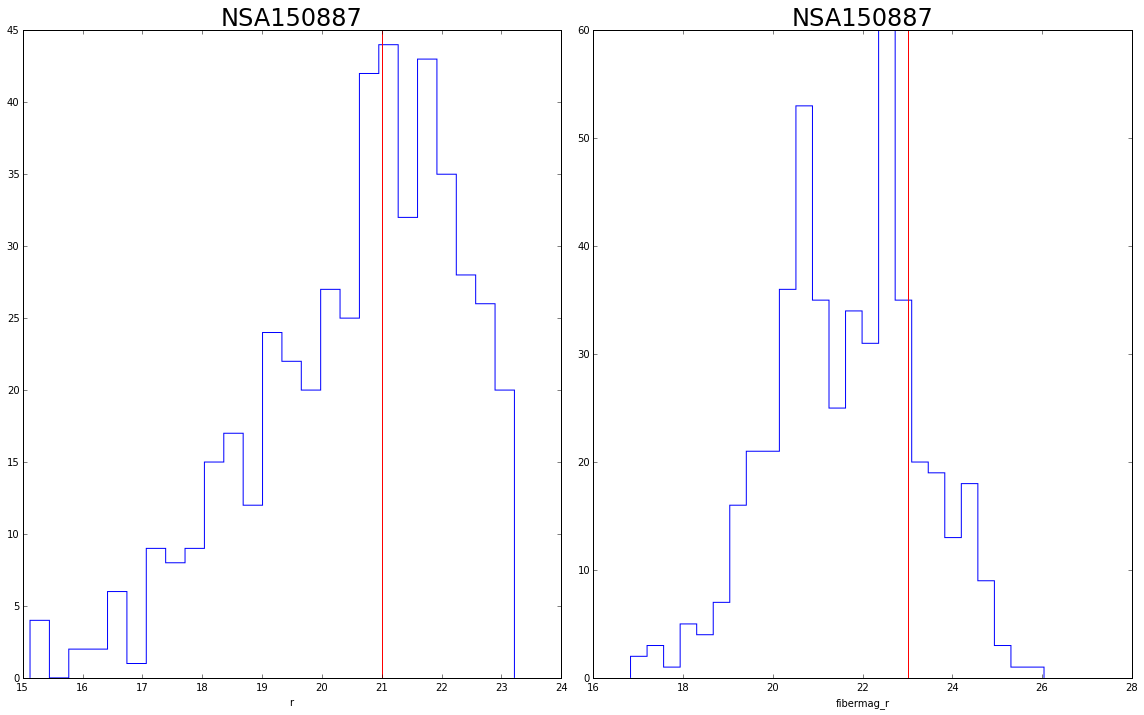

In [14]:
for h in hosts_to_target:
    cat = joined_catalogs[h]
    ranks = rankdct[h]

    plt.figure()
    
    msk = (ranks>0)&(ranks<8)
    plt.subplot(1,2,1)
    plt.hist(cat[msk]['r'],bins=25, histtype='step')
    plt.axvline(21,c='r')
    plt.xlabel('r')
    plt.title(h.name, fontsize=24)
    
    plt.subplot(1,2,2)
    plt.hist(cat[msk]['fibermag_r'],bins=25, histtype='step')
    plt.axvline(23,c='r')
    plt.xlabel('fibermag_r')
    plt.title(h.name, fontsize=24)
    
    plt.tight_layout()

### Check that new ML predictions are fairly complete 

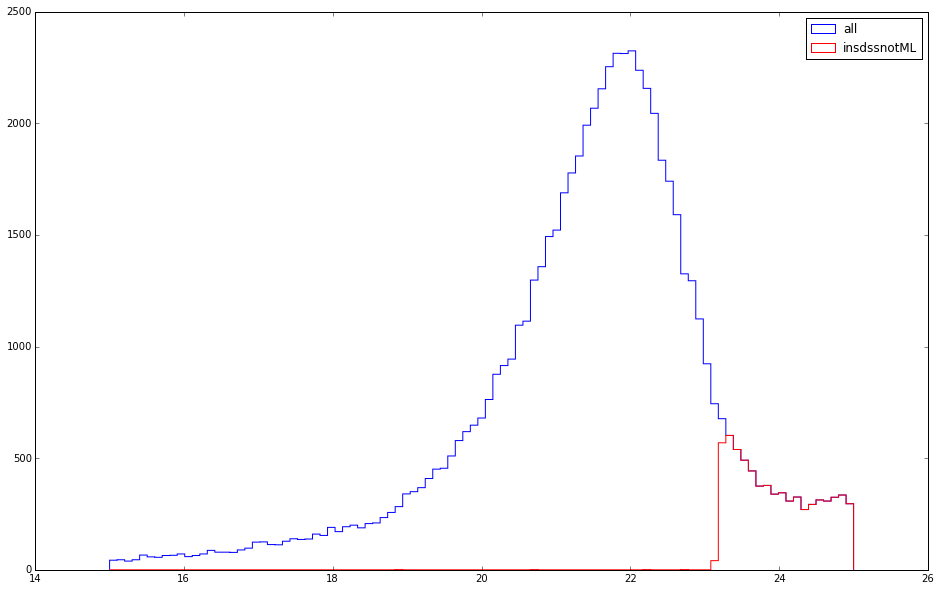

In [17]:

bins = np.linspace(15,25, 100)
notinml = cat['OBJID'].mask
plt.hist(cat['r'], color='b', bins=bins, histtype='step', label='all')
plt.hist(cat['r'][notinml], color='r', bins=bins, histtype='step', label='insdssnotML')
plt.legend(loc=0)
None

### check compared to the *old* mlpred file

In [18]:
mlpred_old = Table.read('catalogs/SAGAobjid_PredictionAug28_SDSS_SDSSwise_v4removed_combinedPs.fits.gz')
mlpred_old['OBJID'].name = 'objID'

In [19]:
# 
joined_catalogs_old = {}
for h in hosts_to_target:
    #filter on manual remove lists *and* REMOVE!=-1
    cat = targeting.remove_targets_with_remlist(h.get_sdss_catalog(), h, 'catalogs/TargetRemoveAug28_2015.csv')
    
    pre_joined = table.join(cat, mlpred_old, join_type='left', keys='objID')
    
    tokeep = pre_joined['REMOVE']==-1
    notobserved = pre_joined['ZQUALITY']<3
    print('removed', np.sum(~tokeep),'for remove list and', np.sum(~notobserved),'b/c observed')
    joined_catalogs_old[h] = pre_joined[tokeep&notobserved]
    highp = pre_joined[p_column_for_ranking]>0.01
    print('n w/ ML pred>0.01 and observed:', np.sum(highp&~notobserved), 'not yet obs:', np.sum(highp&notobserved))

Removed 4 objects for NSA150887
removed 250 for remove list and 722 b/c observed
n w/ ML pred>0.01 and observed: 0 not yet obs: 124


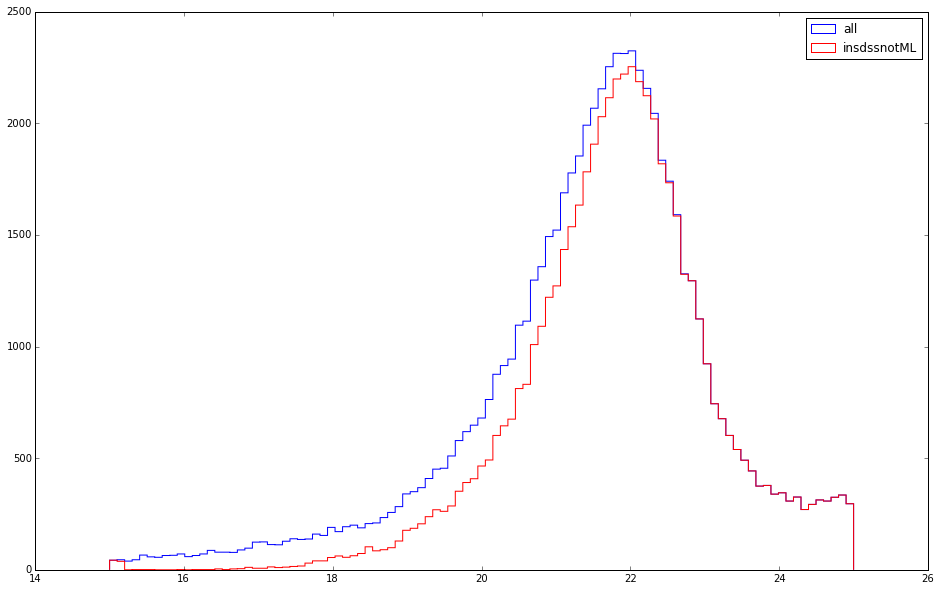

In [20]:
cat = joined_catalogs_old[n150887]
bins = np.linspace(15,25, 100)
notinml = cat['PROBABILITY_CLASS_1'].mask
plt.hist(cat['r'], color='b', bins=bins, histtype='step', label='all')
plt.hist(cat['r'][notinml], color='r', bins=bins, histtype='step', label='insdssnotML')
plt.legend(loc=0)
None

## Now actually generate a catalog 

In [22]:
generated_cats = {}
for h in hosts_to_target:
    print('On host', h.name)
    sys.stdout.flush()

    cat = joined_catalogs[h]
    ranks = rankdct[h]
    
    fnout = 'mmthecto/{0}_nov2015.cat'.format(h.name)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout)
    
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<9)
    generated_cats[h] = mmthecto.generate_catalog(h, cat[msk], ranks[msk], 
                                         repeatflux=3, removefluxdistance=1*u.arcmin,
                                         fnout=fnout, fluxfnout=fluxfnout)

On host NSA150887
Going to write mmthecto/NSA150887_nov2015.cat
Including 4503 targets
Found 73 Flux stars
Removing 34 Flux stars too close to program stars
Could not find psf mags so falling back on regular mags...
Found 255 guide stars


### Have a look at the  input catalog

In [68]:
gcat = generated_cats[h]

In [77]:
ranknum = gcat['rank'].copy()
ranknum[gcat['rank']==''] = '-1'
ranknum = ranknum.astype(int)
{r: np.sum(r==ranknum) for r in set(ranknum)}

{-1: 255, 1: 117, 2: 3, 4: 52, 5: 14, 6: 80, 7: 79, 8: 4275}

In [83]:
msk = (ranknum>1)&(ranknum<6)
targeting.sampled_imagelist(gcat[msk], None, None, names=gcat['rank'][msk])
None

### Have a looksee at the configuration output by xfitfibs 

In [63]:
coords, targets, ranks, fields = mmthecto.parse_cfg_file('mmthecto/NSA150887_nov2015.cfg')

In [65]:
msk = ranks == 2
targeting.sampled_imagelist(coords[msk], None, None, names=targets[msk])

'name ra dec\n1277 348.696642083 4.639955\n2945 348.394260417 4.55277194444\n1278 348.727540833 4.71334444444'